In [49]:
import useful as us


# Data directory
data_dir = 'data_2021/'

# GAUSSIAN FILTERING

In [4]:
import matplotlib.pyplot as plt
import numpy as np
import skimage.io
import scipy.ndimage
from cv2 import filter2D
import skimage.feature

In [183]:
import numpy as np

def gaussians(s, n=4):
    """
    Generates Gaussian kernels and their first and second derivatives.

    Parameters:
    s (float): The standard deviation of the Gaussian distribution.
    n (int, optional): The range multiplier to determine the kernel size. 
                       The range of x values will be from -n*s to +n*s. Default is 4.

    Returns:
    tuple: A tuple containing three numpy arrays:
        - g: The Gaussian kernel.
        - dg: The first derivative of the Gaussian kernel.
        - ddg: The second derivative of the Gaussian kernel.

    The Gaussian kernel is defined as:
        g(x) = (1 / (s * sqrt(2 * pi))) * exp(-x^2 / (2 * s^2))

    The first derivative of the Gaussian kernel is defined as:
        dg(x) = -x / (s^2) * g(x)

    The second derivative of the Gaussian kernel is defined as:
        ddg(x) = -x / (s^2) * dg(x) - 1 / (s^2) * g(x)

    Example:
    >>> g, dg, ddg = gaussians(1.0, 4)
    >>> print(g)    # Gaussian kernel
    >>> print(dg)   # First derivative of the Gaussian kernel
    >>> print(ddg)  # Second derivative of the Gaussian kernel
    """

    # Create a range of x values centered around zero, from -n*s to +n*s
    x = np.arange(-np.ceil(n*s), np.ceil(n*s) + 1)
    x = np.reshape(x, (-1, 1))  # Reshape x into a column vector

    # Gaussian kernel
    g = 1 / (s * np.sqrt(2 * np.pi)) * np.exp(-x**2 / (2 * s**2))
    
    # First derivative of the Gaussian kernel
    dg = -x / (s**2) * g
    
    # Second derivative of the Gaussian kernel
    ddg = -x / (s**2) * dg - 1 / (s**2) * g
    
    return g, dg, ddg

In [182]:
def separable_filtering(image, kernelx, kernely):
    """
    Applies separable filtering to an image.

    Args:
        image: The input image to be filtered.
        kernelx: The kernel for first axis.
        kernely: The kernel for second axis.

    Returns:
        The filtered image.
    """
    kernelx = kernelx.reshape(1, -1)
    kernely = kernely.reshape(-1, 1)
    return filter2D(filter2D(image, -1, kernelx), -1, kernely)

## Kernel

In [181]:
# Gaussian parameter
s = 1

# Generate Gaussian
g, dg, ddg = gaussians(s, 5)

# Kernel
kernel = g @ dg.T 
print(kernel)

# Print the kernel
print(np.round(kernel[3:-3, 3:-3],2))

[[ 1.10516746e-11  7.95872033e-10  1.97667466e-08  1.60538847e-07
   3.59742598e-07  0.00000000e+00 -3.59742598e-07 -1.60538847e-07
  -1.97667466e-08 -7.95872033e-10 -1.10516746e-11]
 [ 9.94840042e-10  7.16421173e-08  1.77934582e-06  1.44512465e-05
   3.23829967e-05  0.00000000e+00 -3.23829967e-05 -1.44512465e-05
  -1.77934582e-06 -7.16421173e-08 -9.94840042e-10]
 [ 3.29445776e-08  2.37246109e-06  5.89238410e-05  4.78559558e-04
   1.07237757e-03  0.00000000e+00 -1.07237757e-03 -4.78559558e-04
  -5.89238410e-05 -2.37246109e-06 -3.29445776e-08]
 [ 4.01347118e-07  2.89024930e-05  7.17839338e-04  5.83004893e-03
   1.30642333e-02  0.00000000e+00 -1.30642333e-02 -5.83004893e-03
  -7.17839338e-04 -2.89024930e-05 -4.01347118e-07]
 [ 1.79871299e-06  1.29531987e-04  3.21713271e-03  2.61284666e-02
   5.85498315e-02  0.00000000e+00 -5.85498315e-02 -2.61284666e-02
  -3.21713271e-03 -1.29531987e-04 -1.79871299e-06]
 [ 2.96557637e-06  2.13562142e-04  5.30415514e-03  4.30785586e-02
   9.65323526e-02  

## Laplacian of the Gaussian

In [184]:
# Load the images
im = skimage.io.imread(f'{data_dir}wood.png').astype(np.float32)
LoG = skimage.io.imread(f'{data_dir}wood_LoG.tif')

# Display the images
us.display_images([im, LoG], ['Original', 'LoG'])

FileNotFoundError: No such file: 'c:\Users\Alejandro\Documents\GitHub\AIA\exam2023\data_2022\wood.png'

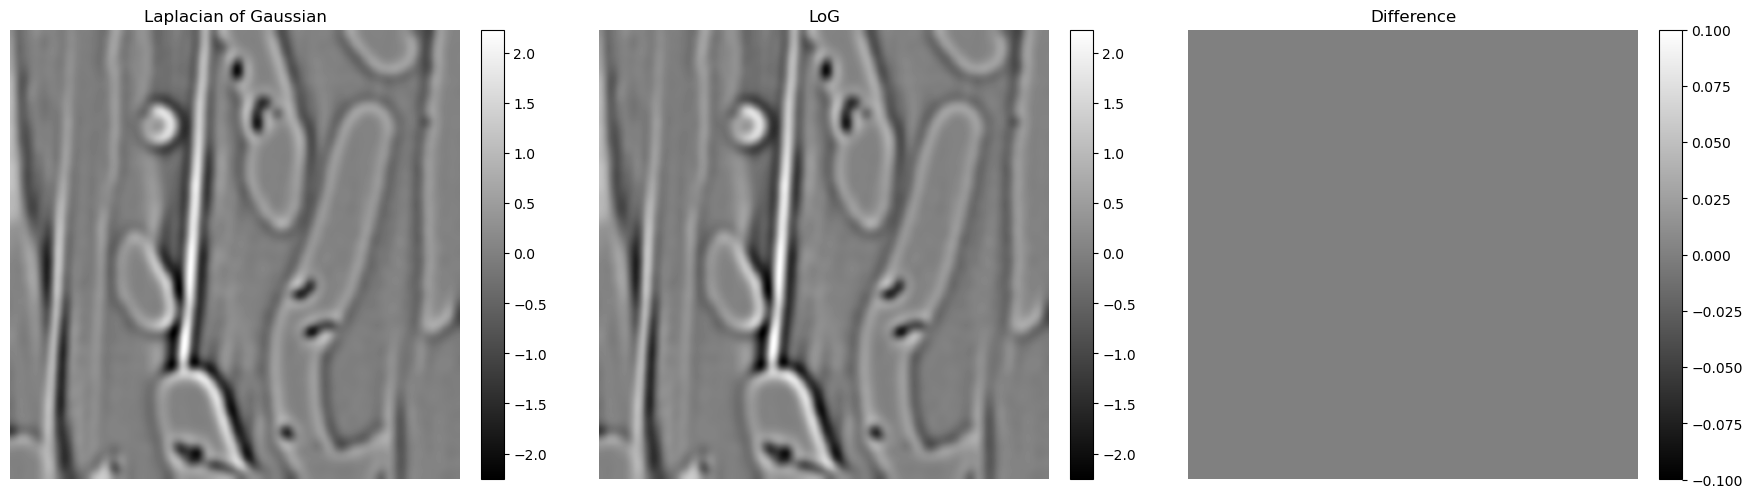

In [ ]:
# Gaussian parameter sigma
s = 5.5 # sigma (parameter of the Gaussian)
g, dg, ddg = gaussians(s)

# Second order Gaussian derivative in x and y directions
Lxx = scipy.ndimage.convolve(scipy.ndimage.convolve(im, ddg), g.T)
Lyy = scipy.ndimage.convolve(scipy.ndimage.convolve(im, ddg.T), g)

# Laplacian of Gaussian
L = Lxx + Lyy

# Display the images
us.display_images([L, LoG, L-LoG], ['Laplacian of Gaussian', 'LoG', 'Difference'])

## Scale-normalized Laplacian

In [50]:
# Data
Lxx = 5.12
Lyy = 7.16
t = 12

# Scale-normalized Laplacian
snL = t * (Lxx + Lyy)
print(f'Scale-normalized Laplacian: {snL:.2f}')

Scale-normalized Laplacian: 147.36


# CURVE SMOOTHING

In [155]:
def regularization_matrix(N, alpha, beta):
    """An NxN matrix for imposing elasticity and rigidity to snakes.
    Arguments: alpha is weigth for second derivative (elasticity),
    beta is weigth for (-)fourth derivative (rigidity)."""
    d = alpha*np.array([-2, 1, 0, 0]) + beta*np.array([-6, 4, -1, 0])
    D = np.fromfunction(lambda i,j: np.minimum((i-j)%N,(j-i)%N), (N,N), dtype=int)
    A = d[np.minimum(D,len(d)-1)]
    return(np.linalg.inv(np.eye(N)-A))

# taken from weekly solutions at gitlab
def curve_length(X):
    d = X - np.roll(X, shift=1, axis=0)
    d = (d**2).sum(axis=1)
    d = (np.sqrt(d)).sum()
    return(d)

## Curve smoothing and length

In [156]:
# Load the data
curve = np.loadtxt(f'{data_dir}hand_noisy.txt')
print(curve.shape)

# Display the data
us.display_points([curve], ['r.'], ['curve'])

# Regularization matrix
X_alpha = regularization_matrix(curve.shape[0], 100, 0) @ curve
X_beta = regularization_matrix(curve.shape[0], 0, 100) @ curve

# Display the data
d = curve_length(X_alpha) - curve_length(X_beta)
print(f'Difference in length between the 2 curves: {d}')

FileNotFoundError: data_2021/hand_noisy.txt not found.

## Mean curvature

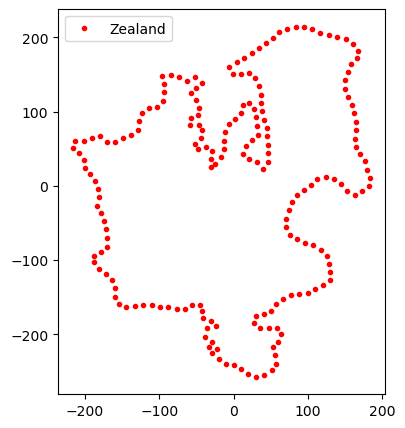

In [ ]:
# Open txt file and display results

# Load the data
bended = np.loadtxt(data_dir + 'zealand.txt')

# Display the data
us.display_points([bended], titles=['Zealand'])

In [ ]:
# Mean curvature of the curve
b = 2 * bended - np.roll(bended, 1, axis=0) - np.roll(bended, -1, axis=0)
b = np.sqrt((b**2).sum(axis=1)).mean()

# Display the result
print(f'Mean curvature: {b:.2f}')

Mean curvature: 5.21


## Smoothing of a point

In [159]:
def smooth_curve(S, alpha, alpha_kernel, beta, beta_kernel):
    """
    Smooth the curve represented by points in S using the specified kernels and parameters.

    Parameters:
    S (ndarray): Array of shape (n, 2) representing n points in 2D space.
    alpha (float): Alpha parameter for the smoothing process.
    alpha_kernel (ndarray): Kernel for the alpha term.
    beta (float): Beta parameter for the smoothing process.
    beta_kernel (ndarray): Kernel for the beta term.

    Returns:
    ndarray: New position of the first point after one iteration of the smoothing process.
    """
    n = len(S)
    if n < len(alpha_kernel) or n < len(beta_kernel):
        raise ValueError("The number of points in S must be at least the length of the kernels.")
    
    # Calculate the alpha term
    alpha_term = sum(alpha_kernel[i] * S[(i - len(alpha_kernel) // 2) % n] for i in range(len(alpha_kernel)))
    
    # Calculate the beta term
    beta_term = sum(beta_kernel[i] * S[(i - len(beta_kernel) // 2) % n] for i in range(len(beta_kernel)))
    
    # Compute the new position of the first point
    new_position = S[0] + alpha * alpha_term + beta * beta_term
    
    return new_position

In [160]:
# The point and its neighbors
S = np.array([[0.1, 2.9], [1.2, 5.4], [3.3, 7.1], [3.5, 0.2], [1.4, 1.1]])

# Parameters
alpha = 0.05
alpha_kernel = np.array([0, 1, -2, 1, 0])
beta = 0.1
beta_kernel = np.array([-1, 4, -6, 4, -1])

# Position of the first point after one iteration of the smoothing process
new_position = smooth_curve(S, alpha, alpha_kernel, beta, beta_kernel)
print(f'Position of the first point after one iteration of the smoothing process: {new_position}')

Position of the first point after one iteration of the smoothing process: [0.52  3.065]


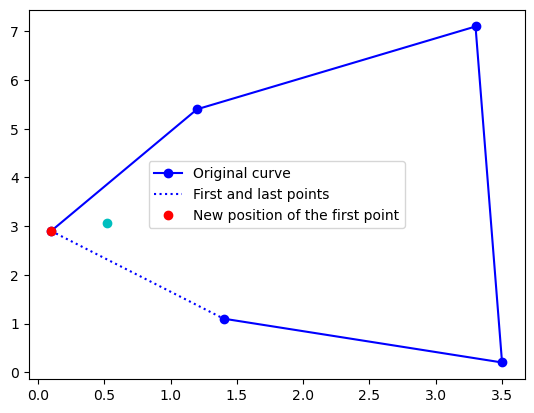

In [162]:
# Visualization
fig, ax = plt.subplots()
ax.plot(S[:,0], S[:,1], 'b-o', S[[0,-1],0], S[[0,-1],1], 'b:')
ax.plot(S[0,0], S[0,1], 'ro', new_position[0], new_position[1], 'co')
# Add a legend
ax.legend(['Original curve', 'First and last points', 'New position of the first point'])
plt.show()

# BLOB DETECTION

## Detect blob at a scale

### Open the data

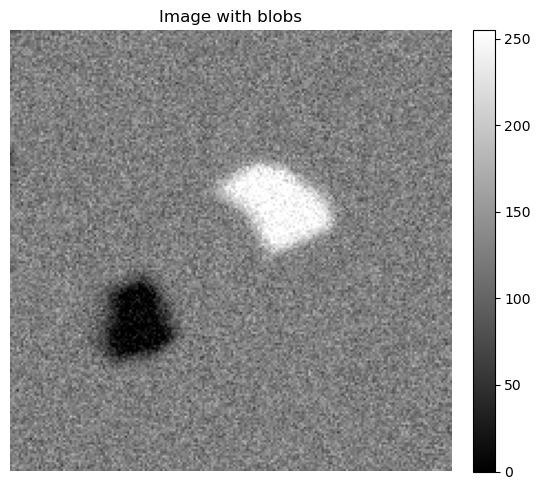

(30, 200, 200)


In [199]:
# Open the image with dark and bright blobs
blobs = skimage.io.imread(f'{data_dir}blobs.png').astype(np.float32)

# Display the image
us.display_images([blobs], ['Image with blobs'])

# Open pre-computed linear laplacian scale-space
blobs_Laplace = skimage.io.imread(f'{data_dir}blobs_Laplace.tif')
print(blobs_Laplace.shape)

### General parameters

In [202]:
# Apply Gaussian filter
t = 16 # variance

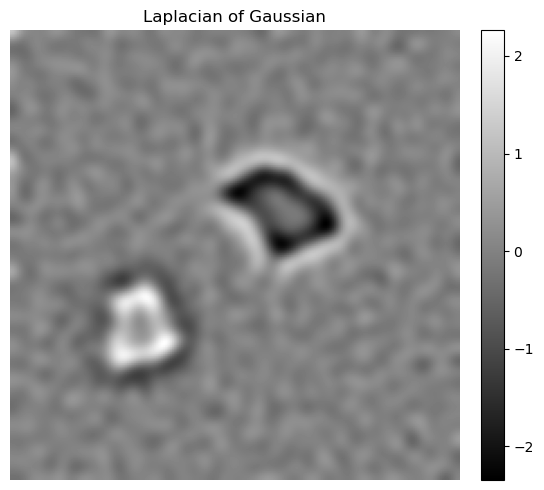

In [195]:
# Gaussian parameter sigma
s = np.sqrt(t) # sigma
g, dg, ddg = gaussians(s)

# Second order Gaussian derivative in x and y directions
Lxx = scipy.ndimage.convolve(scipy.ndimage.convolve(blobs, ddg), g.T)
Lyy = scipy.ndimage.convolve(scipy.ndimage.convolve(blobs, ddg.T), g)
LoG = Lxx + Lyy

# Display the images
us.display_images([LoG], ['Laplacian of Gaussian'])

### Local extrema

In [188]:
def get_local_extrema_2D(L):
    """
    Identifies local extrema in a 2D array.

    This function takes a 2D array as input and identifies the coordinates of the local minima (dark extrema)
    and local maxima (bright extrema) in the array. A local minimum is a pixel that has a lower value than all
    its 8 neighboring pixels, and a local maximum is a pixel that has a higher value than all its 8 neighbors.

    Parameters:
    - L: 2D numpy array. The input array in which local extrema are to be identified.

    Returns:
    - coord_dark: Tuple of arrays (row_indices, col_indices). The coordinates of local minima in the input array.
    - coord_bright: Tuple of arrays (row_indices, col_indices). The coordinates of local maxima in the input array.
    """
    r, c = L.shape
    ct_im = np.zeros((r, c))

    # Iterate over the neighborhood of each pixel
    for i in range(-1, 2):
        for j in range(-1, 2):
            to_row = r - 1 + i
            to_col = c - 1 + j
            ct_im[1:-1, 1:-1] += (L[1:-1, 1:-1] > L[1 + i:to_row, 1 + j:to_col])

    # Identify local minima (dark extrema)
    coord_dark = np.where(ct_im[1:-1, 1:-1] == 8)
    # Identify local maxima (bright extrema)
    coord_bright = np.where(ct_im[1:-1, 1:-1] == 0)

    return coord_dark, coord_bright

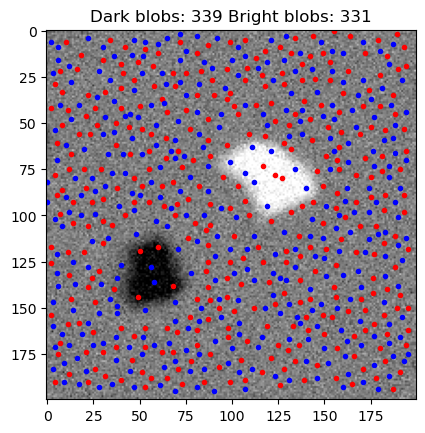

In [192]:
coord_dark, coord_bright = get_local_extrema_2D(LoG)

# Display the result
# Display (not needed for computing the solution)
fig, ax = plt.subplots()
ax.imshow(blobs, cmap='gray')
ax.plot(coord_dark[1], coord_dark[0], '.r')
ax.plot(coord_bright[1], coord_bright[0], '.b')
ax.set_title(f'Dark blobs: {len(coord_dark[0])} Bright blobs: {len(coord_bright[0])}')
plt.show()

### Detect bright blob

In [205]:
# Coordinates and scale of the local maximum (bright blob)
coords = skimage.feature.peak_local_max(-blobs_Laplace, threshold_abs=60) # -blobs_Laplace to find bright blobs. +blobs_Laplace to find dark blobs

sc, r, c = coords[0]
scale = t*(sc+1)

# Display the result
print(f'Local maximum at row {r}, column {c}, scale {scale}')

Local maximum at row 132, column 57, scale 144


### Check

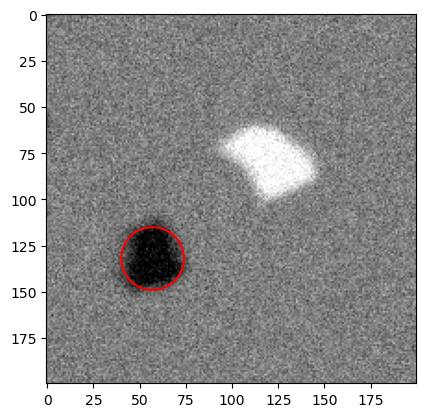

In [206]:
fig, ax = plt.subplots()
ax.imshow(blobs, cmap='gray')
theta = np.linspace(0, 2*np.pi, 200)
d = np.sqrt(2*scale)
x = np.cos(theta)*d + c
y = np.sin(theta)*d + r
ax.plot(x, y, 'r')

## Blob size

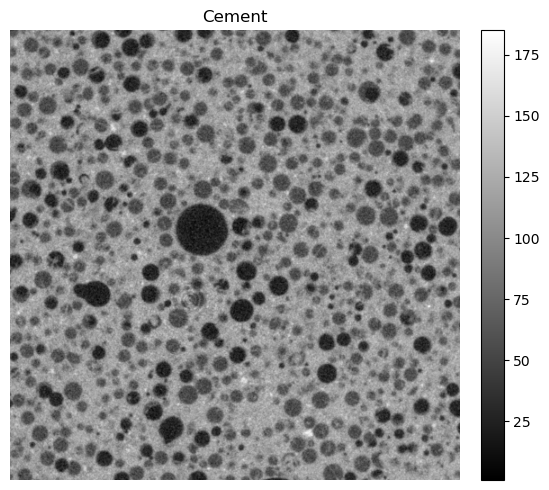

In [ ]:
# Open the image and display it
cement = skimage.io.imread(f'{data_dir}cement.png').astype(np.float32)

# Display the image
us.display_images([cement], ['Cement'])

In [ ]:
# Data for the cement blobs

# Open cement.txt file
cement_txt = np.loadtxt(data_dir + 'cement.txt')

# Show sample of the data
beta = cement_txt[:, 0]
y_coord = cement_txt[:, 1]
x_coord = cement_txt[:, 2]
scale = cement_txt[:, 3]

In [ ]:
# Find the blobs with a beta value greater than 10 (absolute value)
idx = np.where(np.abs(beta) > 10)[0]

# The remaining data
beta = beta[idx]
y_coord = y_coord[idx]
x_coord = x_coord[idx]
scale = scale[idx]

# Diameter = 2*radius = 2*sqrt(2*scale). Average diameter
diameter = 2*np.sqrt(2*scale).mean()

# Print the result
print(f'Average diameter: {diameter:.2f}')

Average diameter: 15.42


## Blob detection at different scales

In [57]:
# The linear scale-space representation has been computed of an specific pixel
L_1 = 28.9 # for t = 1
L_2 = 19.9 # for t = 2
L_3 = 13.7 # for t = 3
L_4 = 9.8 # for t = 4
L_5 = 7.0 # for t = 5

L = np.array([L_1, L_2, L_3, L_4, L_5])
t = np.array([1, 2, 3, 4, 5])

idx_max = np.argmax(L*t)
max = np.max(L*t)
print(f'Maximum at t = {t[idx_max]}') # Large positive value: dark blob
print(f'Maximum value: {max:.2f}')

# Estimate the radius of the blob
radius = np.sqrt(2*t[idx_max])
print(f'Estimated radius: {radius:.2f}')


Maximum at t = 3
Maximum value: 41.10
Estimated radius: 2.45


# FEATURE - BASED SEGMENTATION (DICTIONARY)

## Segment an image

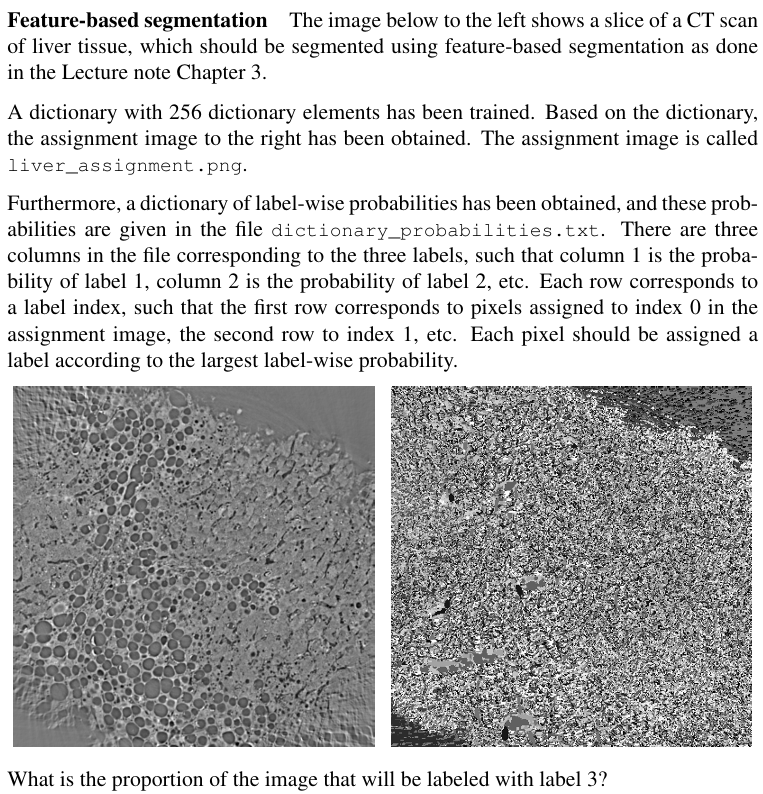

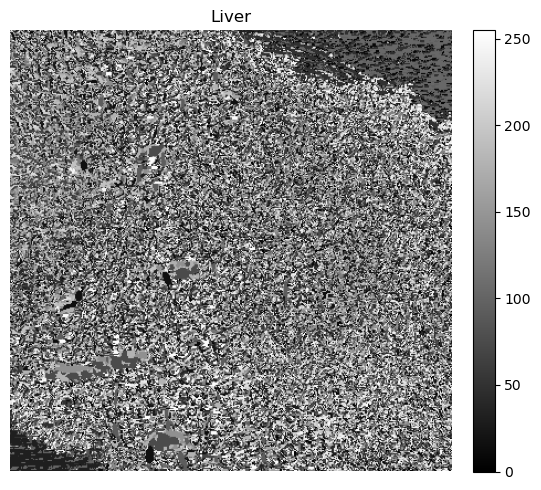

In [ ]:
# Open the image and display it
liver = skimage.io.imread(f'{data_dir}liver_assignment.png') 
us.display_images([liver], ['Liver'])

In [ ]:
# Open the disctionary and display the data
dictionary_probabilities = np.loadtxt(data_dir + 'dictionary_probabilities.txt')

# Print 3 rows of the dictionary
print(dictionary_probabilities[:3])

[[0.5337 0.0036 0.4627]
 [0.3278 0.0111 0.6611]
 [0.8107 0.     0.1893]]


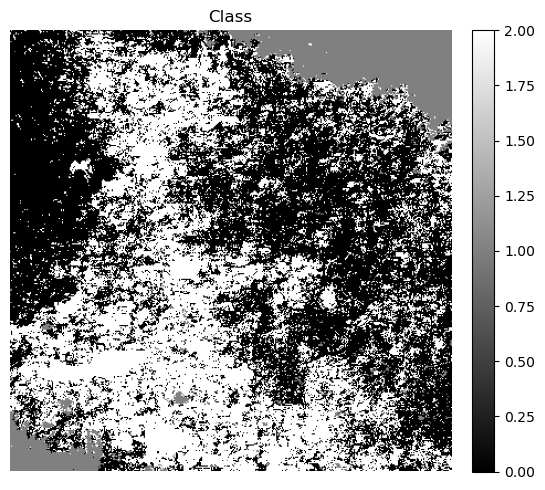

Class 0: 50.18%
Class 1: 8.85%
Class 2: 40.97%


In [ ]:
# Build the probability image
prob_im = dictionary_probabilities[liver] # Each pixel in the image contains the probability of each class

# For each pixel, select the class with the highest probability
class_im = np.argmax(prob_im, axis=2)

# Display the result
us.display_images([class_im], ['Class'])

# Print the result percentage of each class
for i in range(3):
    print(f'Class {i}: {100*(class_im == i).mean():.2f}%')

## Probability of being in a class calculation

In [208]:
image1 = np.array([4, 350, 1])
image2 = np.array([45, 147, 36])

image = image1 + image2
prob = image/image.sum() # Probability of each class
print('Probability of each class:', prob)

Probability of each class: [0.08404803 0.85248714 0.06346484]


## Dictionary clustering

In [185]:
# Open the data
distances = np.loadtxt(data_dir + 'distances.txt')
labels = np.loadtxt(data_dir + 'labels.txt')

# Display the data
print(distances.shape) # (4, 17)
print(labels.shape) # (17,)

# Extract the indexes of the pixels (columns) whose distance to the center of cluster 2 is smaller than all other clusters
idx = np.argmin(distances, axis=0) == 1
print(f'Number of pixels closer to cluster 2: {idx.sum()}')

# Of those pixels, amount of pixels that are labeled as class 1 and class 2
idx1 = labels[idx] == 1
idx2 = labels[idx] == 2
print(f'Number of pixels labeled as class 1: {idx1.sum()}')
print(f'Number of pixels labeled as class 2: {idx2.sum()}')

# Probability of each class
prob = np.array([idx1.sum(), idx2.sum()])/idx.sum()
print(f'Probability of class 1: {prob[0]:.2f}')
print(f'Probability of class 2: {prob[1]:.2f}')


(4, 17)
(17,)
Number of pixels closer to cluster 2: 13
Number of pixels labeled as class 1: 7
Number of pixels labeled as class 2: 6
Probability of class 1: 0.54
Probability of class 2: 0.46


## Other calculations

In [73]:
label_1 = np.array([0, 0, 0, 0, 0.04])
label_2 = np.array([0.01, 0.15, 0.02, 0.01])
label_3 = np.array([0.98, 0.85, 0.98, 0.98, 0.06])

# Mean of the labels
mean_label_1 = label_1.mean()
mean_label_2 = label_2.mean()
mean_label_3 = label_3.mean()

# Print the result
print(f'Mean of label 1: {mean_label_1:.2f}')
print(f'Mean of label 2: {mean_label_2:.2f}')
print(f'Mean of label 3: {mean_label_3:.2f}')

Mean of label 1: 0.01
Mean of label 2: 0.05
Mean of label 3: 0.77


# FEATRUE-BASED IMAGE REGISTRATION

## From covariance matrix

In [3]:
C = np.array([[191955, -937044],[552183, 379358]])

rotation_matrix, rotation_angle = us.compute_rotation_from_covariance(C)
print("Rotation Matrix:\n", rotation_matrix)
print("Rotation Angle (degrees):", rotation_angle)

Rotation Matrix:
 [[ 0.35817796 -0.93365333]
 [ 0.93365333  0.35817796]]
Rotation Angle (degrees): 69.01165964850453


# Point Cloud transformation

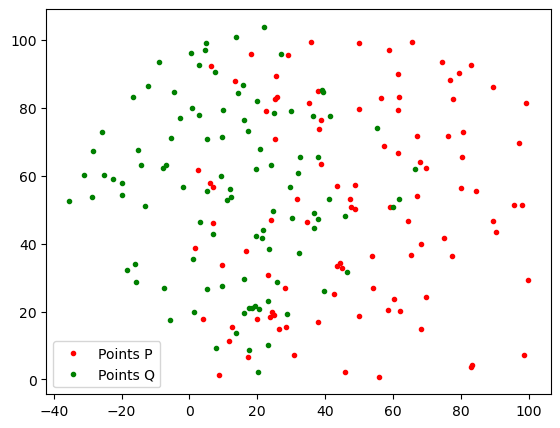

In [ ]:
# Open the txt files
points_p = np.loadtxt(data_dir + 'points_p.txt')
points_q = np.loadtxt(data_dir + 'points_q.txt')

# Display the data
us.display_points([points_p, points_q], titles=['Points P', 'Points Q'])

In [ ]:
# Compute the transformation parameters
scale, translation, rotation_angle = us.compute_transformation(points_p, points_q)

# Output the parameters
print(f"Scale (s): {scale}")
print(f"Translation (t): {translation}")
print(f"Rotation angle (θ) in degrees: {rotation_angle}")

Scale (s): 0.8354531704659556
Translation (t): [17.12345059 -3.63120423]
Rotation angle (θ) in degrees: 48.41113798952755


## Apply transformation

In [95]:
# Load the data
points_p = np.loadtxt(data_dir + 'points_p.txt')
points_q = np.loadtxt(data_dir + 'points_q.txt')

# Parameters
theta = 140 # degrees
theta = np.radians(theta) # Convert to radians

R = np.array([[np.cos(theta), -np.sin(theta)], [np.sin(theta), np.cos(theta)]])
t = np.array([36, 13]).reshape((2,1))
s = 1.7

# Transform the points q into the coordinate system of p
points_p_= R.transpose() @ (points_q - t) / s

print(points_p_.shape) # (2, 30)

# Array with the distances between the points
distances = np.sqrt(((points_p - points_p_)**2).sum(axis=0))

# Number of points with distance more than 2
n = (distances > 2).sum()
print(f'Number of points with distance more than 2: {n}')

(2, 30)
Number of points with distance more than 2: 2


# SIFT

## SIFT matching

In [184]:
# Open the txt files
sift_1_coord = np.loadtxt(data_dir + 'SIFT_1_coordinates.txt')
sift_2_coord = np.loadtxt(data_dir + 'SIFT_2_coordinates.txt')

print(sift_1_coord.shape)

sift_1_desc = np.loadtxt(data_dir + 'SIFT_1_descriptors.txt')
sift_2_desc = np.loadtxt(data_dir + 'SIFT_2_descriptors.txt')

# Display the data
us.display_points([sift_1_coord, sift_2_coord], titles=['SIFT 1', 'SIFT 2'])

# Obtain the translations
mean_translation, translation_length, matched_distances = us.sift_matching_translation(sift_1_coord, sift_2_coord, sift_1_desc, sift_2_desc)

# Display the results
print(f"Mean translation: {mean_translation}")
print(f"Translation length: {translation_length}")
print(f"Matched distances: {matched_distances}")

FileNotFoundError: data_2021/SIFT_1_coordinates.txt not found.

# MRF

## Energy

### Change in the energy

#### For multiple pixels

In [99]:
import numpy as np

# Given pixel values before flipping
vals = np.array([[7, 7, 8], [2, 2, 2]])

# Old configuration (gray pixels with mean 8, red pixels with mean 2)
mu_gray = 8
mu_red = 2

# New configuration (flipped pixels: red to gray and gray to red)
mu_gray_new = 2
mu_red_new = 8

# Smoothness parameters
beta_vertical = 16
beta_horizontal = 12

# Edges
vertical_edges = 8
horizontal_edges = 6

# Calculate the data term for the old configuration
data_term_old = ((vals - np.array([[mu_gray], [mu_red]])) ** 2).sum()

# Calculate the smoothness term for the old configuration
smoothness_term_old = vertical_edges * beta_vertical + horizontal_edges * beta_horizontal

# Total energy for the old configuration
E_old = data_term_old + smoothness_term_old


# Calculate the data term for the new configuration
data_term_new = ((vals - np.array([[mu_red_new], [mu_gray_new]])) ** 2).sum()

# Calculate the smoothness term for the new configuration
smoothness_term_new = 2 * beta_horizontal

# Total energy for the new configuration
E_new = data_term_new + smoothness_term_new

# Change in energy
change = E_new - E_old

print(f'The change in energy is {change}')


The change in energy is -176


#### For one pixel

In [100]:
# Value of the pixel
val = 52

# Parameters
mu_blue = 30
mu_red = 20
beta = 125 # smoothness parameter
n_neighbours = 1 # number of neighbours of other color

# Calculate the energy
E_current = (mu_red - val)**2 + beta * n_neighbours
E_new = (mu_blue - val)**2 + beta * (4-n_neighbours)

# Change in energy
change = E_new - E_current
print(f'The change in energy is {change}')

The change in energy is -290


#### For an image

In [106]:
def prior_energy(S, beta):
    return beta * ((S[:-1] != S[1:]).sum() + (S[:, :-1] != S[:, 1:]).sum()) 

def likelihood_energy(S, I, mu):
    return ((mu[S] - I)**2).sum()

In [125]:
# Open the image
I = skimage.io.imread(f'{data_dir}circly.png')

# Other parameters
mu = np.array([70, 120, 180])
beta = 100

In [126]:
U = (I.reshape(I.shape+(1,)) - mu.reshape(1,1,-1))**2
S0 = np.argmin(U, axis=2)

prior = prior_energy(S0, beta)
print(f'{prior = }')
likelihood = likelihood_energy(S0, I, mu)
print(f'{likelihood = }')
print(f'Question 11: {prior + likelihood}')

prior = 104300
likelihood = 883802
Question 11: 988102


## Binary segmentation (maxflow)

In [128]:
# Open the image
I = skimage.io.imread(f'{data_dir}bony.png')

# Other parameters
mu = np.array([130, 190])
beta = 3000


In [130]:
import maxflow

U = (I.reshape(I.shape+(1,)) - mu.reshape(1,1,-1))**2
g = maxflow.Graph[float]()
nodeids = g.add_grid_nodes(I.shape)
g.add_grid_edges(nodeids, beta)
g.add_grid_tedges(nodeids, U[:,:,1], U[:,:,0])
g.maxflow()
S = g.get_grid_segments(nodeids)
print(f'Maximun a posteriori solution: {S.sum()}')

Maximun a posteriori solution: 5810


### Prior energy

In [5]:
I = np.array([[1, 1, 1, 1, 2, 2, 2],
              [1, 2, 2, 1, 2, 3, 2],
              [2, 3, 2, 1, 2, 3, 2],
              [2, 2, 2, 1, 1, 3, 2],
              [1, 2, 1, 1, 1, 1, 1,]]) 

U2 = 10*(np.abs(np.diff(I, axis=0)).sum() + np.abs(np.diff(I, axis=1)).sum())
print(f'Prior energy: {U2}')

Prior energy: 300


# SNAKE

## External force

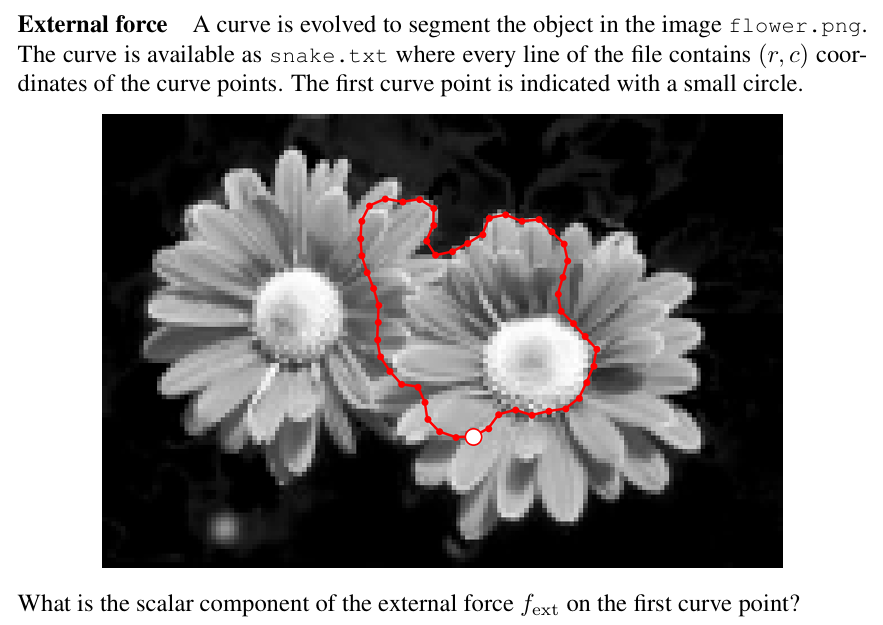

C:\Users\Alejandro\AppData\Local\Temp\ipykernel_18704\3260471307.py:2: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  im = skimage.io.imread(f'{data_dir}frame.png').astype(np.float)/255 # Normalization [0, 1]


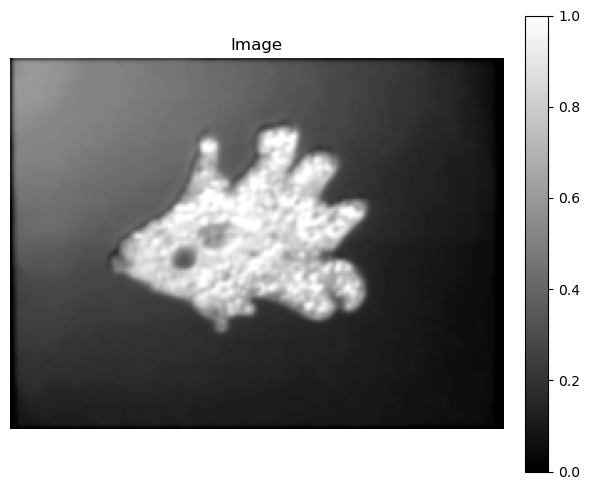

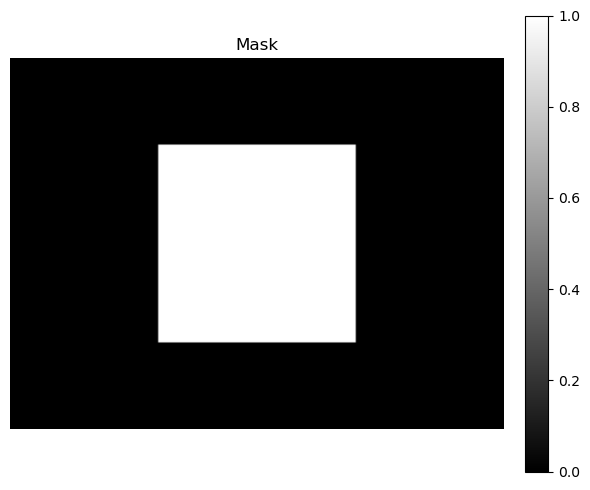

In [143]:
# Open the image
im = skimage.io.imread(f'{data_dir}frame.png').astype(np.float)/255 # Normalization [0, 1]
us.display_images([im], ['Image'])

# Snake in txt
# snake = np.loadtxt(data_dir + 'snake.txt').astype(int)
# us.display_points([snake], titles=['Snake'])

# Mask of the snake (inside the snake is 1, outside is 0)
# mask = skimage.draw.polygon2mask(im.shape, snake)

# Create own snake
mask = np.zeros(im.shape, dtype=bool)
mask[im.shape[0]//2-40:im.shape[0]//2+40, im.shape[1]//2-40:im.shape[1]//2+40] = 1

# Display the mask
us.display_images([mask], ['Mask'])


In [154]:
# Mean intensity inside and outside the snake
mean_inside = im[mask == 1].mean()
mean_outside = im[mask == 0].mean()

# Force
# Point of interest
# p = np.array([snake[0, 0], snake[0, 1]])
p = [im.shape[0]/2+39.5, im.shape[1]/2-40.5]

# Value of the pixel at the point of interest
print(p[0], p[1])
val = im[int(p[0]), int(p[1])]
force = (mean_inside - mean_outside) * (2*val - mean_inside - mean_outside)

# Display the force
print(f'Force: {force.mean()}')

114.5 59.5
Force: -0.19141631805513498


## External force by hand

In [7]:
mean_inside = 0
mean_outside = 90*90/(100*200 - 90*90) # Mean intensity outside the snake

# Force
val = 0
force = (mean_inside - mean_outside) * (2*val - mean_inside - mean_outside)

# Display the force
print(f'Force: {force}')

Force: 0.4633147376597698


# SURFACE COST

## In an image

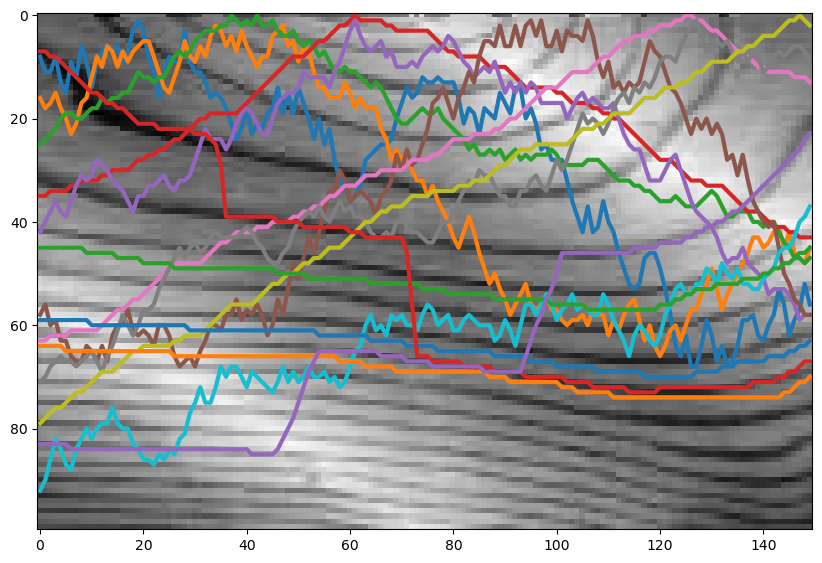

In [ ]:
# Open the image
im = skimage.io.imread(f'{data_dir}lines.png')

# Open the txt file
lines= np.loadtxt(data_dir + 'lines.txt').astype(int)

# Display the image
fig, ax = plt.subplots(figsize=(10, 10))
ax.imshow(im, cmap='gray')
ax.plot(lines.T, linewidth=3)

In [ ]:
# Calculate the on-surface cost
x = np.arange(im.shape[1]) # x-coordinates of the image

# Sum the intensity values of the pixels that the surface pass through
costs = [im[lines[i, :], x].sum() for i in range(lines.shape[0])]

# Convert to a float array
costs = np.array(costs).astype(float)

# Check the smoothness constraint
# Calculate the maximun absolute difference between consecutive row coordinates for each surface
difs = np.max(np.abs(lines[:, :-1] - lines[:, 1:]), axis=1)

# Index of the surface with the lowest cost that meets the smoothness constraint
max_delta = 3
idx = np.argmin(costs + (costs.max())*(difs > max_delta))

# Display the result
print(f'Index: {idx}')

Index: 7


## In a txt file (pixel matrix)

Optimal Segmentation Line Index (0-based): 2
Minimum Cost: 198
Costs for each possible segmentation line: [262, 212, 198, 280, 352]
Bright Costs (row-wise): [ 67  35  53 101  96]
Dark Costs (row-wise): [53 85 67 19 24]


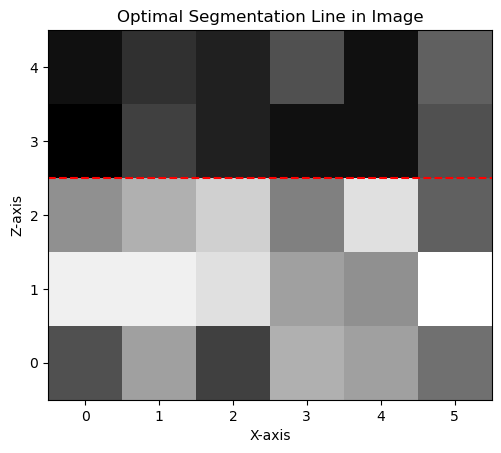

In [165]:
# Step 1: Load the image data from the file
# Assuming the file 'layers.txt' is in the same directory as the script
I = np.loadtxt(data_dir + 'layers.txt').astype(int)

# Step 2: Calculate bright and dark costs for each pixel
c_bright = 20 - I
c_dark = I

# Step 3: Calculate row-wise sums for bright and dark costs
bright_sums = c_bright.sum(axis=1)
dark_sums = c_dark.sum(axis=1)

# Step 4: Initialize a list to store the total cost for each segmentation line
costs = []

# Step 5: Compute the total cost for each possible segmentation line
for s in range(I.shape[0]):
    # Calculate the sum of bright costs for rows from 0 to s (inclusive)
    bright_cost = bright_sums[:s+1].sum()
    # Calculate the sum of dark costs for rows from s+1 to the end
    dark_cost = dark_sums[s+1:].sum()
    # Compute the total cost for this segmentation line
    total_cost = bright_cost + dark_cost
    # Append the total cost to the list
    costs.append(total_cost)

# Step 6: Find the minimum cost and its corresponding index
min_cost = min(costs)
optimal_line = costs.index(min_cost)

# Step 7: Print the results
print("Optimal Segmentation Line Index (0-based):", optimal_line)
print("Minimum Cost:", min_cost)
print("Costs for each possible segmentation line:", costs)
print("Bright Costs (row-wise):", bright_sums)
print("Dark Costs (row-wise):", dark_sums)

# Step 8: (Optional) Visualize the results using matplotlib
import matplotlib.pyplot as plt

fig, ax = plt.subplots()
# Plot the original image intensities
ax.imshow(I, cmap='gray', origin='lower')
# Highlight the optimal segmentation line
ax.axhline(y=optimal_line + 0.5, color='red', linestyle='--')

# Add labels and title
ax.set_xlabel('X-axis')
ax.set_ylabel('Z-axis')
ax.set_title('Optimal Segmentation Line in Image')
plt.show()



## Cost of the path

In [20]:
# The paths
path_1 = np.array([80, 93, 91, 82, 92, 86, 87, 88, 85, 82])
path_2 = np.array([24, 25, 39, 32, 21, 21, 32, 21, 39, 30])

# The costs
cost_1 = ((path_1 - 90) ** 2).sum()
cost_2 = ((path_2 - 30) ** 2).sum()

# Total cost
total_cost = cost_1 + cost_2
print(f'Total cost: {total_cost}')

Total cost: 770


## Mean absolute distance between paths

In [5]:
# Load data
cost = np.loadtxt(data_dir + 'cost.txt')
print(cost.shape)

(6, 10)


In [10]:
# First path with constraint delta = 0
s0 = cost.sum(axis=1) # sum of all the rows
s0 = np.argmin(s0) # row with the minimum cost
s0_path = cost[s0, :] # cost of the path
print(s0)

# Second path with constraint delta = 5
s5 = np.argmin(cost, axis=0)
s5_path = cost[s5, np.arange(cost.shape[1])]
print(s5)

# Mean absolute difference
d = np.abs(s0 - s5).mean()
print(f'Mean absolute difference: {d:.2f}')

1
[4 3 0 0 1 0 1 1 1 3]
Mean absolute difference: 1.00


# MLP

## MLP with formulas

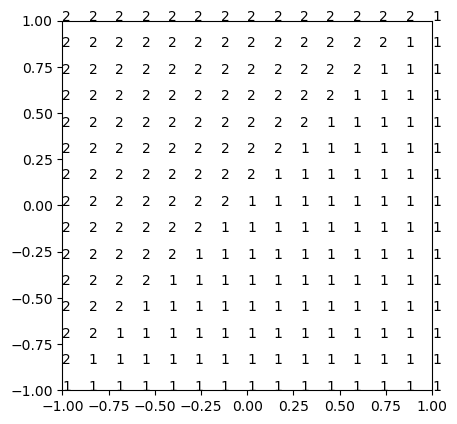

In [ ]:
def predict(x1, x2):
    h2 = max(10 * x2 - 10.1 * x1 + 0.3, 0.0)
    h1 = max(-9.1 * x2 + 9 * x1 + 0.7, 0.0)
    y2 = 5.4 * h2 - 4.6 * h1 - 0.5
    y1 = -5.9 * h2 + 5.6 * h1 + 0.2    
    return((y2 > y1) + 1)

fig, ax = plt.subplots()
ax.set_xlim(-1, 1)
ax.set_ylim(-1, 1)
ax.set_aspect('equal')
for x1 in np.linspace(-1, 1, 15, endpoint=True):
    for x2 in np.linspace(-1, 1, 15, endpoint=True):
        ax.text(x1, x2, predict(x1, x2))
plt.show()

## MLP with weights

### Example 1 (with files)

In [40]:
def mlp(x):
    h1 = np.maximum(np.concatenate(([1], x)) @ W1, 0)
    h2 = np.maximum(np.concatenate(([1], h1)) @ W2, 0)
    y_hat = np.concatenate(([1], h2)) @ W3
    y = np.exp(y_hat)
    y = y/y.sum()
    return np.argmax(y)


In [41]:
# Open the data
W1 = np.loadtxt(data_dir + 'W1.txt')
W2 = np.loadtxt(data_dir + 'W2.txt')
W3 = np.loadtxt(data_dir + 'W3.txt')

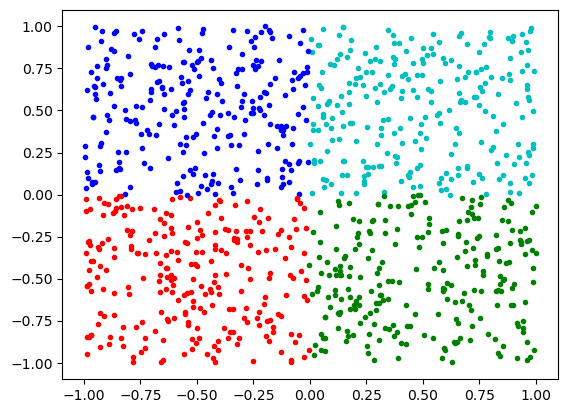

In [42]:
colors = 'rgbc'
fig, ax = plt.subplots()
for i in range(1000):
    x = np.random.uniform(low=-1, high=1, size=2)
    y = mlp(x)
    ax.plot(x[0], x[1], '.'+colors[y])

### Example 2 (with array)

In [177]:
def mlp(x, *weights):
    # Initialize the input with bias term
    x = np.concatenate(([1], x))
    
    # Forward pass through each layer
    for W in weights[:-1]:
        # Calculate the pre-activation values
        h = x @ W.T
        # Apply ReLU activation function
        x = np.concatenate(([1], np.maximum(h, 0)))
    
    # Output layer (no ReLU activation, just the weighted sum)
    y_hat = x @ weights[-1].T
    
    # Apply softmax function
    y = np.exp(y_hat)
    y /= y.sum()
    
    return y, np.argmax(y)

In [175]:
# Define the weights
W1 = np.array([[0.2, -1.3], [-0.3, 1.8], [-1.7, 1.6]])
W2 = np.array([[-1.4, 1.5, -0.5, 0.9],[0.2, 1.2, -0.9, 1.7]])

# Values
x1 = 2.5

In [178]:
# Define the weights
W1 = np.array([[0.2, -1.3], [-0.3, 1.8], [-1.7, 1.6]])
W2 = np.array([[-1.4, 1.5, -0.5, 0.9], [0.2, 1.2, -0.9, 1.7]])

# Define the input
x1 = np.array([2.5])

# Get the output
y, predicted_class = mlp(x1, W1, W2)
print(f'Probabilities: {y}')
print(f'Predicted class: {predicted_class}')

Probabilities: [0.14679034 0.85320966]
Predicted class: 1


## MLP backpropagation

In [ ]:
x = 0.5
h = [1, 0.8, -0.1+0.9*x, -0.1*x]
h = [max(n,0) for n in h]
yhat = [0.4*h[0], 0.5*h[0]+0.1*h[1]-0.2*h[2], 0.8*h[2]-0.2*h[3]]
y = [np.exp(n) for n in yhat]
y = [n/sum(y) for n in y]

# PARTIAL DERIVATIVES

In [ ]:
#  Consider a 5-class classification network with softmax activation in the last layer and a cross entropy loss
y = np.array([0.05, 0.2, 0.4, 0.1, 0.25])
t = np.array([0, 1, 0, 0, 0])
print(-t/y)

[ 0. -5.  0.  0.  0.]


# NETWORK

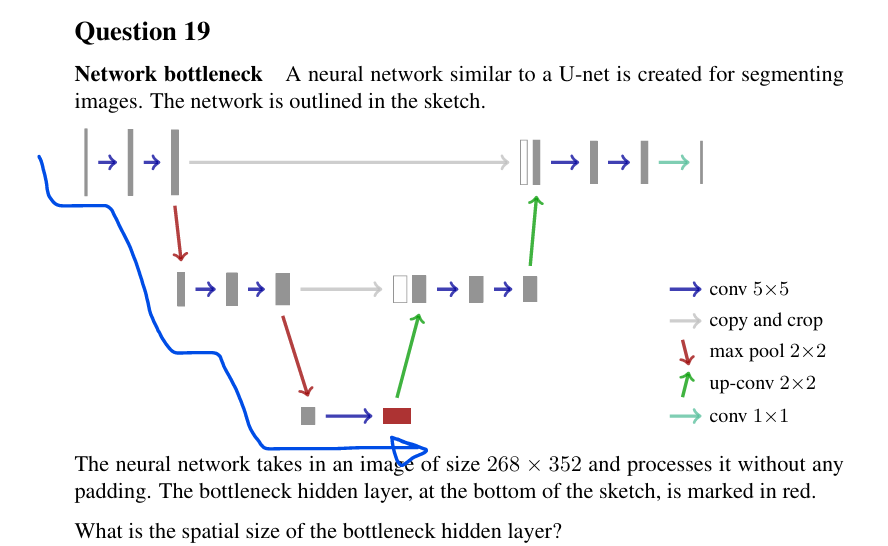

In [43]:
# Original size
dims = np.array([510, 510])

down1 = (dims - 4 - 4)/2  # after two conv5x5 layers and moxpool2x2
down2 = (down1 - 4 - 4)/2 # after second block of two conv5x5 layers and moxpool2x2
bottom = (down2 - 4) # just one conv in the third block
print(bottom)

[117.5 117.5]


## Inverse procedure

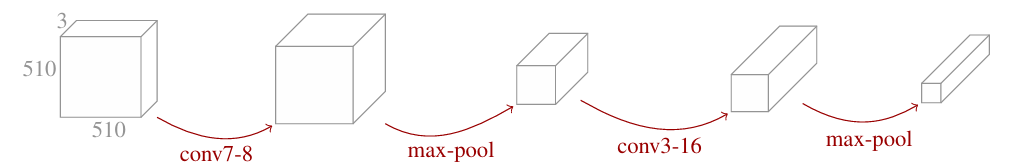

In [44]:
# One output pixel -> initial receptive field size 1
# max pool doubles -> 2 (receptive field before max pool)
# 3x3 convolution adds 2 -> 4
# max pool doubles -> 8
# 7x7 convolution adds 6 -> 14
r = (1 * 2 + 2) * 2 + 6
print(f'Receptive Field: {r}x{r}')

Receptive Field: 14x14


## Learnable parameters

In [48]:
# Image has 3 channels
# 8 convolutional kernels of 7x7 (no padding) (1 bias neuron)
n_param = (1 + 7*7*3)*8
# 16 convolutional kernels of 3x3 (no padding) (1 bias neuron)
n_param += (1 + 3*3*8)*16
# Max pooling 2x2 and downscaling

print(f'Number of parameters: {n_param}')

Number of parameters: 2352


# CLASSIFICATION

## Classification loss

In [35]:
# Open the data
matrix = np.loadtxt(data_dir + 'in_t_out.txt')

P = matrix[:, :3]
T = matrix[:, 3].astype(int)
Y_hat = matrix[:, 4:]

y = np.exp(Y_hat)
y = y/y.sum(axis=1, keepdims=True)

loss = -np.log(y[range(len(y)), T]).sum()
print(f'Question 14: {loss}')

Question 14: 4.936206870617411


## Another example of classification loss

In [170]:
# The data
y_hat = np.array([0.5, 8.2, 6.9, -0.1, 0.3])

# The calculation
# Element-wise exponentiation
y = np.exp(y_hat)

# Normalization
y = y/y.sum()

loss = -np.log(y[1])
print(f'Question 14: {loss}')

Question 14: 0.2418505830446608
